# Setup

In [23]:
import os, sys

sys.path.append(os.path.abspath(os.path.join("../../..")))  # access sibling directories
sys.path.append(os.path.abspath(os.path.join("../../../../BayesFlow_dev/BayesFlow/")))

from src.python.settings import summary_meta_validation_2, probability_meta_validation_2
from src.python.models import HierarchicalSdtMptSimulator
from src.python.metrics import performance_metrics, bootstrapped_metrics
from src.python.helpers import (
    log_with_inf_noise_addition,
    computation_times,
    get_repeated_predictions,
)
from src.python.visualization import (
    plot_approximations,
    plot_computation_times,
    plot_calibration_curve_repetition_uncertainty,
)

import bayesflow as bf
import numpy as np

np.set_printoptions(suppress=True)
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt

# Load data

In [2]:
comparison_folder = os.path.join(
    os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),
    "data",
    "02_bridge_sampling_comparison",
    "non_nested_models",
)
bridge_file = "2022_12_02_BF_BS"
NN_fixed_file = "2023_07_06_BF_NN"

bridge = pd.read_csv(os.path.join(comparison_folder, bridge_file), sep=" ").reset_index(
    drop=True
)
NN_fixed = pd.read_csv(os.path.join(comparison_folder, NN_fixed_file))

results_list = [bridge, NN_fixed]

In [3]:
NN_fixed

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.986348,1.365247e-02,0,1.384144e-02,3272.36167,0.002102,0.158629
1,2,0,0.974817,2.518262e-02,0,2.583317e-02,3272.36167,0.002102,0.158629
2,3,0,1.000000,6.694834e-16,0,6.694834e-16,3272.36167,0.002102,0.158629
3,4,1,0.205285,7.947150e-01,1,3.871276e+00,3272.36167,0.002102,0.158629
4,5,0,0.999760,2.395562e-04,0,2.396136e-04,3272.36167,0.002102,0.158629
...,...,...,...,...,...,...,...,...,...
95,96,0,0.999986,1.370747e-05,0,1.370766e-05,3272.36167,0.002102,0.158629
96,97,0,0.533463,4.665369e-01,0,8.745440e-01,3272.36167,0.002102,0.158629
97,98,1,0.000000,1.000000e+00,1,inf,3272.36167,0.002102,0.158629
98,99,1,0.000002,9.999977e-01,1,4.415047e+05,3272.36167,0.002102,0.158629


# Calculate performance metrics

In [4]:
n_bootstrap = 1000
names = ["Bridge sampling", "Neural network"]
metrics = ["Accuracy", "ROC AUC", "MAE", "RMSE", "Log score", "SBC"]

# Calculate performance metrics
perf_metrics = performance_metrics(
    results_list, names=names, metrics=metrics, model_prior=0.5
)

# Calculate bootstrapped performance metrics
metrics_means, metrics_ses = bootstrapped_metrics(
    results_list, n_bootstrap=1000, names=names, metrics=metrics, model_prior=0.5
)

In [5]:
# Raw results
perf_metrics

,Accuracy,ROC AUC,MAE,RMSE,Log score,SBC
Bridge sampling,0.95,0.9852,0.095463,0.218608,0.154887,-0.006345
Neural network,0.95,0.9868,0.092486,0.209165,0.140565,-0.004403


In [6]:
# Bootstrapped means
metrics_means

,Accuracy,ROC AUC,MAE,RMSE,Log score,SBC
Bridge sampling,0.95010,0.985272,0.095138,0.214966,0.154186,-0.004442
Neural network,0.94976,0.986801,0.092324,0.206115,0.140149,-0.002684


In [7]:
# Bootstrapped standard errors
metrics_ses

,Accuracy,ROC AUC,MAE,RMSE,Log score,SBC
Bridge sampling,0.022356,0.008969,0.020284,0.035660,0.043650,0.044602
Neural network,0.022274,0.007868,0.019215,0.033751,0.036871,0.044572


In [8]:
# Convert to latex table
metrics_means = metrics_means.round(2).drop(
    "ROC AUC", axis=1
)  # drop ROC AUC column as results do not add much information
metrics_ses = metrics_ses.round(2).drop(
    "ROC AUC", axis=1
)  # drop ROC AUC column as results do not add much information

for row in range(metrics_means.shape[0]):
    for col in range(metrics_means.shape[1]):
        metrics_means.iloc[row, col] = (
            f"{metrics_means.iloc[row,col]}" + f" ({metrics_ses.iloc[row,col]})"
        )

print(
    metrics_means.style.to_latex(position="h", position_float="centering", hrules=True)
)

\begin{table}[h]
\centering
\begin{tabular}{llllll}
\toprule
 & Accuracy & MAE & RMSE & Log score & SBC \\
\midrule
Bridge sampling & 0.95 (0.02) & 0.1 (0.02) & 0.21 (0.04) & 0.15 (0.04) & -0.0 (0.04) \\
Neural network & 0.95 (0.02) & 0.09 (0.02) & 0.21 (0.03) & 0.14 (0.04) & -0.0 (0.04) \\
\bottomrule
\end{tabular}
\end{table}



In [9]:
# How do the proportions of selected models look like?

print("True proportion = {}".format(bridge["true_model"].mean()))
print("Bridge Sampling proportion = {}".format(bridge["selected_model"].mean()))
print("NN proportion = {}".format(NN_fixed["selected_model"].mean()))

True proportion = 0.5
Bridge Sampling proportion = 0.51
NN proportion = 0.49


# Plot PMPs & log BFs

In [10]:
# Compute Log BFs

log_bridge_bfs = log_with_inf_noise_addition(bridge)
log_NN_fixed_bfs = log_with_inf_noise_addition(NN_fixed)

Dataset with infinite BF: 15
Dataset with infinite BF: 97


In [11]:
model_names = ["SDT", "MPT"]

## BS vs fixed NN

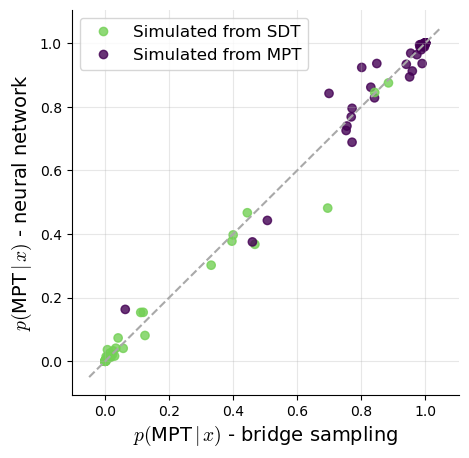

In [12]:
# PMPs
plot_approximations(
    bridge,
    NN_fixed,
    approximated_outcome="PMPs",
    NN_name="neural network",
    model_names=model_names,
    save=False,
)

Dataset with infinite BF: 15
Dataset with infinite BF: 97


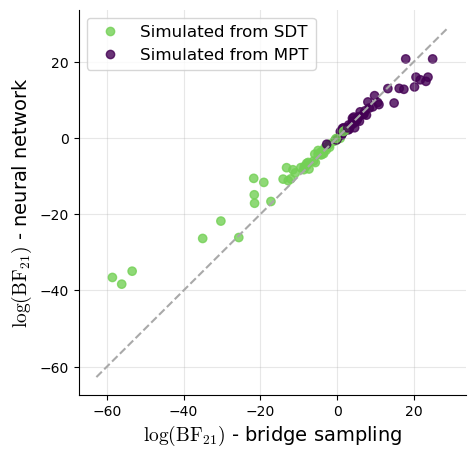

In [13]:
# Log BFs
plot_approximations(
    bridge,
    NN_fixed,
    approximated_outcome="Log BFs",
    NN_name="neural network",
    model_names=model_names,
    save=True,
)

# of included datasets: 85


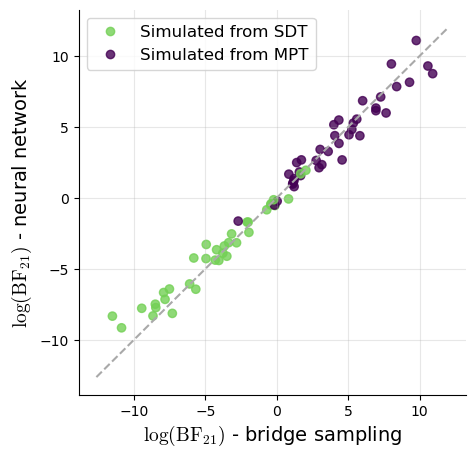

In [14]:
# Log Bfs with filter
filter_high = bridge["bayes_factor"] < 100000
filter_low = bridge["bayes_factor"] > 0.00001
bridge_filtered = bridge[filter_high & filter_low].reset_index(drop=True)
NN_fixed_filtered = NN_fixed[filter_high & filter_low].reset_index(drop=True)
print("# of included datasets: {}".format(min([sum(filter_high), sum(filter_low)])))

plot_approximations(
    bridge_filtered,
    NN_fixed_filtered,
    approximated_outcome="Log BFs",
    NN_name="neural network",
    model_names=model_names,
    save=False,
)

# Find biggest discrepancies and compare implications

In [15]:
# Find biggest PMP discrepancies
divergence_fixed = np.argmax(abs(bridge["m1_prob"] - NN_fixed["m1_prob"]))

In [16]:
# Look up respective BFs: Bridge vs. fixed network
print(f'BF Bridge sampling: {bridge.loc[divergence_fixed, "bayes_factor"]}')
print(f'BF NN: {NN_fixed.loc[divergence_fixed, "bayes_factor"]}')

BF Bridge sampling: 2.27794104065373
BF NN: 0.9274381773289224


# Plot computation times as function of data sets

In [17]:
# Calculate computation times
results_time_list = computation_times(results_list)

In [18]:
# Mean computation times per phase
# Bridge Sampling
print(
    "Stan: {}seconds / {}minutes".format(
        round(np.mean(bridge["stan_time"]), 2),
        round((np.mean(bridge["stan_time"]) / 60), 2),
    )
)
print(
    "Bridge: {}seconds / {}minutes".format(
        round(np.mean(bridge["bridge_time"]), 2),
        round(np.mean(bridge["bridge_time"]) / 60),
        2,
    )
)

# NN fixed
print(
    "NN training: {}seconds / {}minutes".format(
        round(np.mean(NN_fixed["training_time"]), 2),
        round(np.mean(NN_fixed["training_time"]) / 60),
        2,
    )
)
print("NN inference: {}seconds".format(np.mean(NN_fixed["inference_time"])))

Stan: 173.02seconds / 2.88minutes
Bridge: 53.58seconds / 1minutes
NN training: 3272.36seconds / 55minutes
NN inference: 0.002102441999995701seconds


In [19]:
# total bridge sampling time in hours
print((np.sum(bridge["stan_time"]) + np.sum(bridge["bridge_time"])) / 60 / 60)
# total NN time in minutes
print((np.sum(NN_fixed["training_time"][0]) + np.sum(NN_fixed["inference_time"])) / 60)

6.294525547888544
54.54286523999999


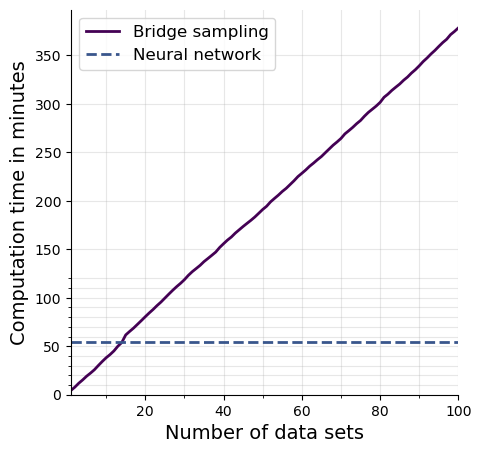

In [20]:
plot_computation_times(results_time_list, names=names, save=False)

In [21]:
# Get minimum number of datasets for which NNs are faster than bridge sampling

print(
    np.where(results_time_list[0] > results_time_list[1])[0][0] + 1
)  # +1 as numpy uses 0-based indexing

15


# Put plots together for publication

In [24]:
# Prepare calibration plot

# Sample size
n_clusters = 25
n_obs = 50

# Generative models
sdtmpt_model = HierarchicalSdtMptSimulator()

sdt_simulator = partial(
    sdtmpt_model.generate_batch, model_index=0, n_clusters=n_clusters, n_obs=n_obs
)
mpt_simulator = partial(
    sdtmpt_model.generate_batch, model_index=1, n_clusters=n_clusters, n_obs=n_obs
)
meta_model = bf.simulation.MultiGenerativeModel([sdt_simulator, mpt_simulator])

# Load network
summary_net = bf.summary_networks.HierarchicalNetwork([
    bf.networks.DeepSet(dense_s1_args=summary_meta_validation_2['level_1']['dense_s1_args'],
                        dense_s2_args=summary_meta_validation_2['level_1']['dense_s2_args'],
                        dense_s3_args=summary_meta_validation_2['level_1']['dense_s3_args']), 
    bf.networks.DeepSet(summary_dim=128,
                        dense_s1_args=summary_meta_validation_2['level_2']['dense_s1_args'],
                        dense_s2_args=summary_meta_validation_2['level_2']['dense_s2_args'],
                        dense_s3_args=summary_meta_validation_2['level_2']['dense_s3_args']) 
])
probability_net = bf.inference_networks.PMPNetwork(num_models=2, 
                                                    dense_args=probability_meta_validation_2['dense_args'], 
                                                    dropout=False)
amortizer = bf.amortizers.AmortizedModelComparison(probability_net, 
                                                    summary_net,
                                                    loss_fun=partial(bf.losses.log_loss, label_smoothing=None))

# Training steps
epochs = 50
iterations_per_epoch = 1000
learning_rate = 0.00025

# Checkpoint path for loading pretrained network and saving the final network
checkpoint_path = "C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models"

trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=meta_model,
    default_lr=learning_rate,
    checkpoint_path=checkpoint_path
)

# Get repeated predictions for calibration curve with repetition uncertainty
n_repetitions = 25

m_true_r, m_soft_r = get_repeated_predictions(
    probability_net,
    summary_net,
    trainer,
    meta_model,
    n_models=2,
    n_repetitions=n_repetitions,
)

INFO:root:Loaded loss history from C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models\history_50.pkl.
INFO:root:Networks loaded from C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models\ckpt-50
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Median ECE = 0.009402513105973538
Median accuracy = 0.931


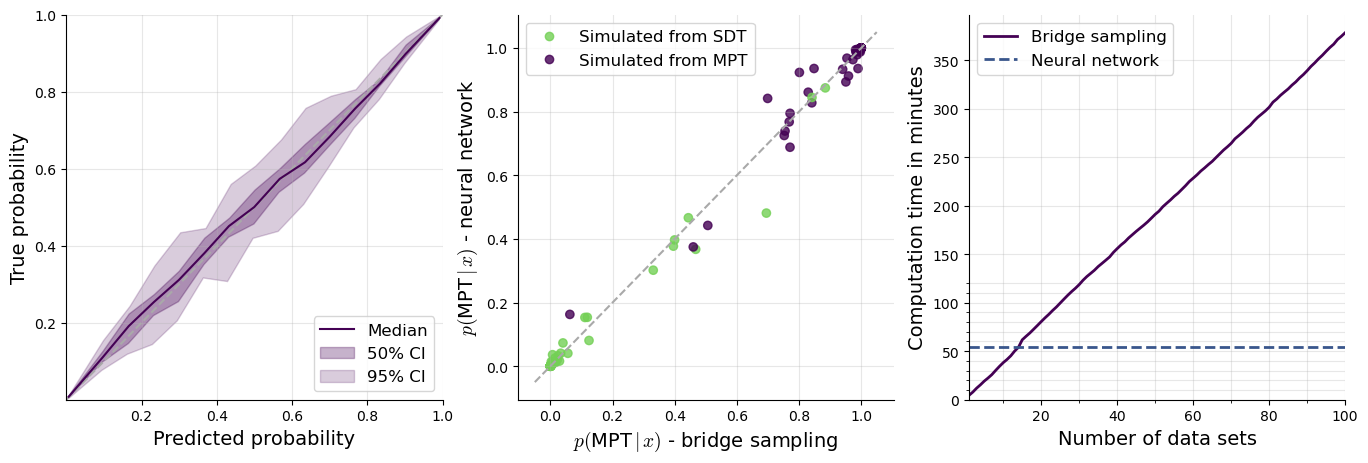

In [25]:
# Plot everything together
f, ax = plt.subplots(1, 3, figsize=(16.5, 5))
plot_calibration_curve_repetition_uncertainty(
    m_true_r[:, :, 1],
    m_soft_r[:, :, 1],
    narrow_ci=[0.25, 0.75],
    wide_ci=[0.025, 0.975],
    n_bins=15,
    ax=ax[0],
    print_accuracy=True,
    xlabel=True,
    ylabel=True,
    title=None,
    show_ece=True,
    show_legend=True,
)
plot_approximations(
    bridge,
    NN_fixed,
    approximated_outcome="PMPs",
    NN_name="neural network",
    model_names=model_names,
    ax=ax[1],
)
plot_computation_times(results_time_list, names=names, ax=ax[2])

plt.savefig("BS_vs_NN_SDTMPT.pdf", dpi=300, bbox_inches="tight")